# Modélisation des équations pour le cancer
## Taux d'hyper-recombinaison

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
%matplotlib inline

### Idée discutée pendant la visio
$\frac{dN}{dR} = I - k(R)R$
- $N$ taux d'hyper-recombinaison
- $R$ risque relatif de cancer
- $k(R) = c_1 R(6 - R)$
- $I$ ???

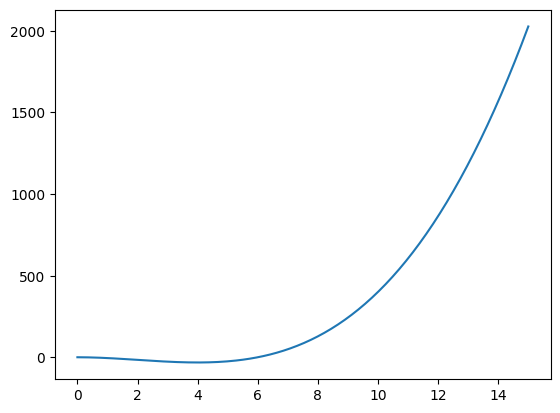

In [17]:
I = 1
c1 = 1
relative_cancer_risk = np.linspace(0, 15, 200).reshape(-1, 1)
k_R = c1 * relative_cancer_risk * (6 - relative_cancer_risk)
derivative_hyper_recombination_rate = I - c1 * k_R * relative_cancer_risk
plt.plot(relative_cancer_risk, derivative_hyper_recombination_rate)
plt.show()

### Modélisation du taux d'hyper-recombinaison
$\frac{dN}{dRR} = c_1 \frac{RR_0^2}{4} - c_1 RR (RR_0 - RR)$
- $c_1$ constante
- $\frac{RR_0}{2}$ endroit où la parabole va s'annuler en son sommet

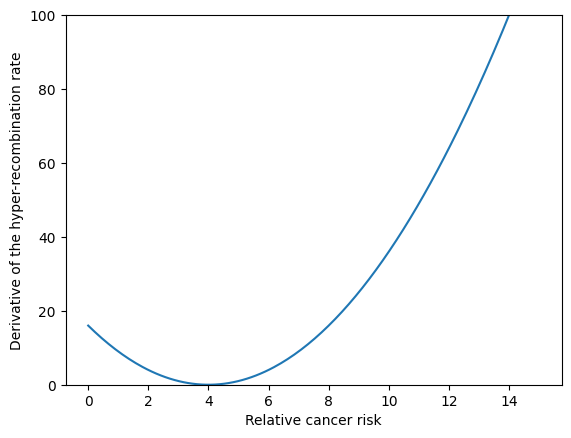

In [18]:
c1 = 1
rr0 = 8
relative_cancer_risk = np.linspace(0, 15, 200).reshape(-1, 1)
derivative_hyper_recombination_rate = c1 * relative_cancer_risk * (relative_cancer_risk - rr0) + c1 * rr0**2 / 4

plt.plot(relative_cancer_risk, derivative_hyper_recombination_rate)
plt.ylim(0, 100)
plt.xlabel("Relative cancer risk")
plt.ylabel("Derivative of the hyper-recombination rate")
plt.show()

### En intégrant
$N(R) = \frac{c_1}{3} RR^3 -  \frac{c_1 RR_0}{2} RR^2 + \frac{c_1 RR_0^2}{4} RR + n_1$
- $n_1$ constante d'intégration obtenue grâce à la condition $N(1) = 0$,

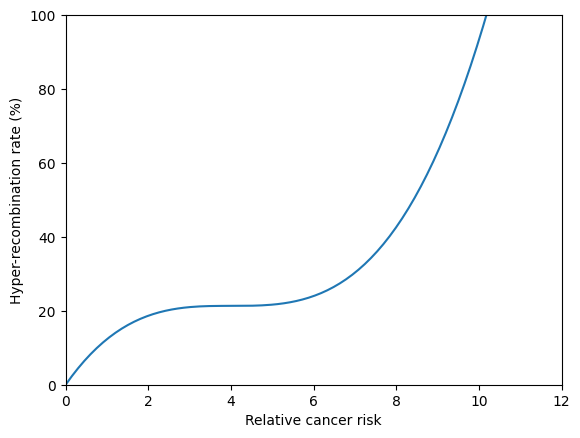

In [19]:
n1 = 0
hyper_recombination_rate = (c1 / 3) * relative_cancer_risk**3 - (rr0 / 2) * c1 * relative_cancer_risk**2 + c1 * (rr0**2 / 4) * relative_cancer_risk + n1

plt.plot(relative_cancer_risk, hyper_recombination_rate)
plt.xlim(0,12)
plt.ylim(0, 100)
plt.xlabel("Relative cancer risk")
plt.ylabel("Hyper-recombination rate (%)")
plt.show()

### Inférence des paramètres

In [20]:
data_frame = pd.read_csv("donnees_laura_2024_cancers.csv")

print(data_frame.head())

    RR  Plasmide  HPRT   MRE11  nuclease  G2/M  G1/S  Evasion
0  1.0       3.2  10.0   5.000      22.7   1.1   0.0     0.00
1  1.4      29.0  26.0  16.000      60.0   1.0   0.0     0.63
2  2.0      27.0   NaN  12.000      65.0   1.0   3.0     1.50
3  4.2      32.0  57.0   7.411      44.0   3.0   4.0    15.90
4  3.4      31.5  34.0   8.250       NaN   4.0   0.0    18.20


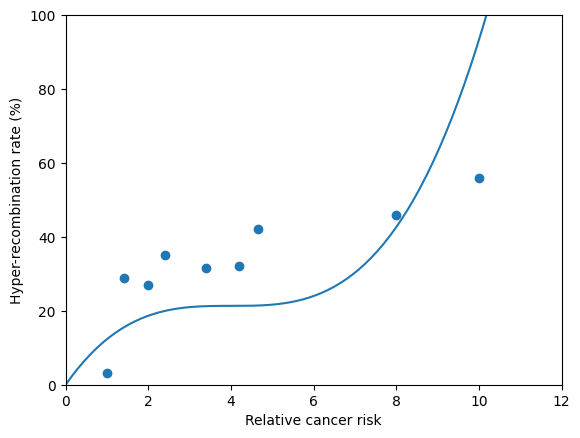

In [21]:
plt.scatter(data_frame.RR, data_frame.Plasmide)
plt.plot(relative_cancer_risk, hyper_recombination_rate)

plt.xlim(0,12)
plt.ylim(0, 100)
plt.xlabel("Relative cancer risk")
plt.ylabel("Hyper-recombination rate (%)")
plt.show()

In [22]:
# Transformation des données en polynome de degré 3
poly = PolynomialFeatures(degree=3)
relative_cancer_risk_polynomial = poly.fit_transform(data_frame.RR.to_numpy().reshape(-1, 1))


model = LinearRegression(fit_intercept=False)
model.fit(relative_cancer_risk_polynomial, data_frame.Plasmide)

regression_coefs = model.coef_

print(f"Coefficients: {regression_coefs}")

Coefficients: [-5.92538984 22.58251764 -3.74990604  0.21215736]


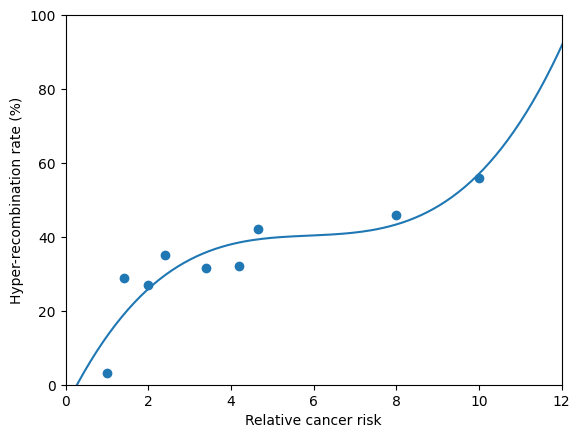

In [23]:
# Afficher la courbe avec les paramètres estimés grâce aux données
fitted_hyper_recombination_rate = regression_coefs[0] + regression_coefs[1] * relative_cancer_risk + regression_coefs[2] * relative_cancer_risk**2 + regression_coefs[3] * relative_cancer_risk**3
plt.plot(relative_cancer_risk, fitted_hyper_recombination_rate)
plt.scatter(data_frame.RR, data_frame.Plasmide)
plt.xlim(0,12)
plt.ylim(0, 100)
plt.xlabel("Relative cancer risk")
plt.ylabel("Hyper-recombination rate (%)")
plt.savefig("FIGURES/hyper_recombination_rate.png")
plt.show()

In [24]:
c1_fitted = 3 * regression_coefs[3]
print(f"Valeur de c1 inférée grâce aux données: {c1_fitted}")

D_fitted = -2 * regression_coefs[2] / c1_fitted
print(f"Valeur de D inférée grâce aux données: {D_fitted}")

Valeur de c1 inférée grâce aux données: 0.6364720815431362
Valeur de D inférée grâce aux données: 11.783410919288439


- $\frac{c_1}{3} = 0.21215 => c_1 = 0.6364$
- $-\frac{c_1 D}{2} = -3.74990604 => D = \frac{2 \times 3.74990604}{c_1} = 11.783$

In [25]:
n0 = (c1_fitted * D_fitted / 2) - (c1_fitted / 3) - (c1_fitted * D_fitted**2 / 4)
print(f"Valeur de n0 pour respecter la condition initiale N(1) = 0 : {n0}")

Valeur de n0 pour respecter la condition initiale N(1) = 0 : -18.555593198474167


### Inférence avec la contrainte N(1) = 0

Coefficients estimés: - c1 = 0.8950649646884954
- D = 12.46176025011956



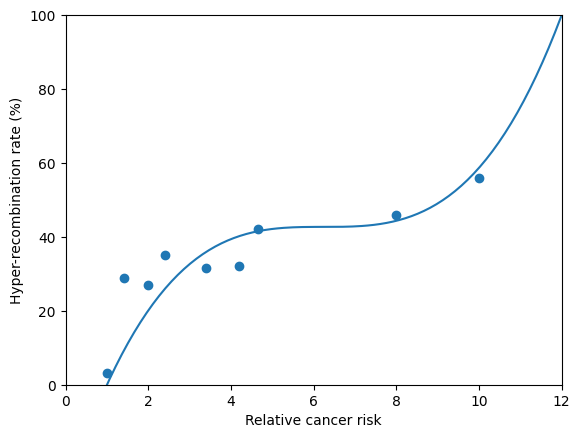

In [26]:
def hyper_recombination_constrained(x, c1, D):
    n1 = c1 * (D / 2) - (c1 / 3) - (c1 * D**2 / 4)
    return (c1 / 3) * x**3 - (c1 * D / 2) * x**2 + (c1 * D**2 / 4) * x + n1

initial_parameters_polynomial = [0.63, 11.7]

fitted_parameters_constrained, fitted_cov = curve_fit(hyper_recombination_constrained, data_frame.RR, data_frame.Plasmide, p0=initial_parameters_polynomial)

c1_fitted, D_fitted = fitted_parameters_constrained

print(f"Coefficients estimés: - c1 = {c1_fitted}\n- D = {D_fitted}\n")

hyper_recombination_constrained_fitted = hyper_recombination_constrained(relative_cancer_risk, c1_fitted, D_fitted)
    
plt.scatter(data_frame.RR, data_frame.Plasmide)
plt.plot(relative_cancer_risk, hyper_recombination_constrained_fitted)
plt.xlim(0,12)
plt.ylim(0, 100)
plt.xlabel("Relative cancer risk")
plt.ylabel("Hyper-recombination rate (%)")
plt.savefig("FIGURES/hyper_recombination_rate_constrained.png")
plt.show()

## Taux d'évasion du cycle G2/M
$\frac{dG}{dR} = c_2 G (1 - \frac{G}{K})$

Soit :<br>
$G(R) = K(1 + (\frac{K}{g_0} - 1) e^{-c_2 R})^{-1}$
- $c_2$ constante, raideur de la fonction logistique
- $K$ capacité limite, pourcentage maximal d'évasion
- $g_0$ pourcentage d'évasion pour les syndromes du groupe $I$ 

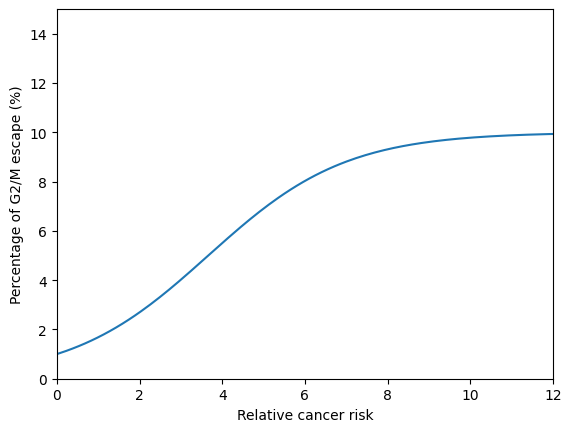

In [27]:
K = 10
g0 = 1
c2 = 0.6
g2m_escape = K / (1 + (K / g0 - 1) * np.exp(-c2 * (relative_cancer_risk)))

plt.plot(relative_cancer_risk, g2m_escape)
plt.ylim(0, 15)
plt.xlim(0, 12)
plt.ylabel("Percentage of G2/M escape (%)")
plt.xlabel("Relative cancer risk")
plt.show()

### Inférence des paramètres

Coefficients estimés: - K = 10.98523606515237
- g0 = 0.5178495571790147
- c2 = 0.5473703186061141


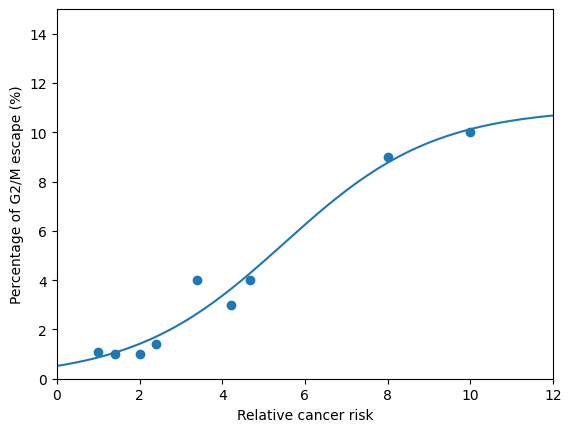

In [28]:
def logistic_func(x, k, x0, c):
    return k / (1 + (k / x0 - 1) * np.exp(-c * (x)))

initial_parameters_guess = [10, 1, 0.6]

fitted_parameters, pcov = curve_fit(logistic_func, data_frame.RR, data_frame["G2/M"], p0=initial_parameters_guess)

K_fitted, g0_fitted, c2_fitted = fitted_parameters

print(f"Coefficients estimés: - K = {K_fitted}\n- g0 = {g0_fitted}\n- c2 = {c2_fitted}")

g2m_escape_fitted = logistic_func(relative_cancer_risk, K_fitted, g0_fitted, c2_fitted)
    
plt.scatter(data_frame.RR, data_frame["G2/M"])
plt.plot(relative_cancer_risk, g2m_escape_fitted)
plt.xlim(0,12)
plt.ylim(0, 15)
plt.xlabel("Relative cancer risk")
plt.ylabel("Percentage of G2/M escape (%)")
plt.savefig("FIGURES/g2m_escaped_rate.png")
plt.show()

- $K = 10.985$
- $g_0 = 0.518$
- $c_2 = 0.547$

## Produit du taux d'hyper-recombinaison et du taux d'évasion
$(G \times N)(R) = K (\frac{c_1}{3} R^3 -  \frac{c_1 D}{2} R^2 + \frac{c_1 D^2}{4} R + n_0) ((\frac{K}{g_0} - 1) e^{-c_2 R})^{-1}$

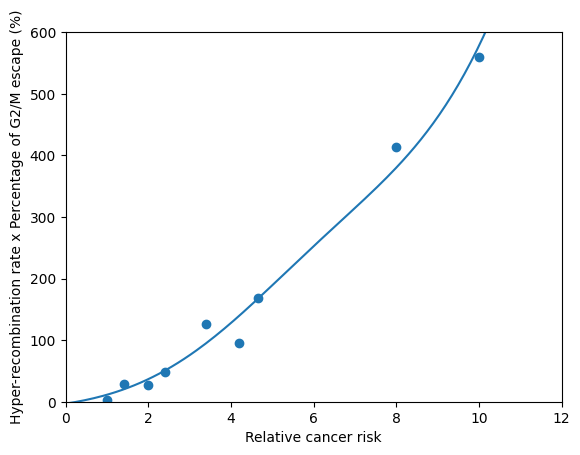

In [32]:
product = fitted_hyper_recombination_rate * g2m_escape_fitted

plt.scatter(data_frame.RR, data_frame["G2/M"] * data_frame.Plasmide)
plt.plot(relative_cancer_risk, product)
plt.ylim(0, 600)
plt.xlim(0, 12)
plt.ylabel("Hyper-recombination rate x Percentage of G2/M escape (%)")
plt.xlabel("Relative cancer risk")
plt.savefig("FIGURES/recombination_x_g2m_escape.png")
plt.show()

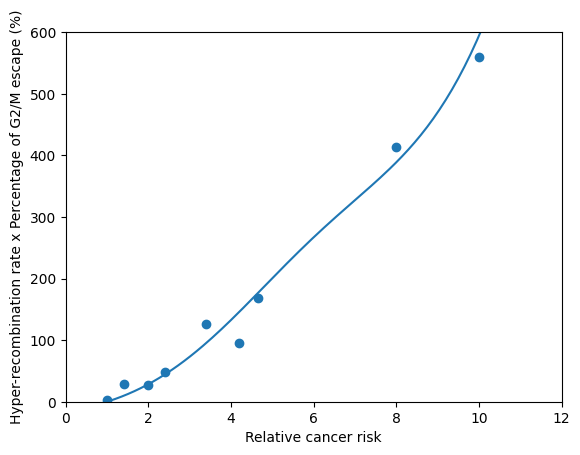

In [33]:
product_constrained = hyper_recombination_constrained_fitted * g2m_escape_fitted

plt.scatter(data_frame.RR, data_frame["G2/M"] * data_frame.Plasmide)
plt.plot(relative_cancer_risk, product_constrained)
plt.ylim(0, 600)
plt.xlim(0, 12)
plt.ylabel("Hyper-recombination rate x Percentage of G2/M escape (%)")
plt.xlabel("Relative cancer risk")
plt.savefig("FIGURES/recombination_x_g2m_escape_constrained.png")
plt.show()